## **Reinforcement Learning: TD(n) and Mountain Car**

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from collections import defaultdict
import math
import random

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
env = gym.make('MountainCar-v0')

In [ ]:
# StateSpace : {Car Position, Car Velocity}
stateSpaceSize = env.observation_space
print(stateSpaceSize)

Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)


In [ ]:
# ActionSpace: {0: Left, 1: Stop, 2: Right}
actionSpaceSize = env.action_space.n
print(actionSpaceSize)

3


In [ ]:
def round_state(state) :
  state[0] = round(state[0],1)
  state[1] = round(state[1],2)
  return state

In [ ]:
env.reset()
action = env.action_space.sample()
obs, reward, done, info = env.step(action)
print("obs=",obs,"reward=",reward,"done=",done,"info=",info)

state = tuple(round_state(obs))
Q = defaultdict(lambda: np.zeros(actionSpaceSize))
Q[state][action] = 1
Q

obs= [-0.40524973 -0.00087524] reward= -1.0 done= False info= {}


defaultdict(<function __main__.<lambda>>, {(-0.4, -0.0): array([0., 1., 0.])})

In [ ]:
env = gym.make('MountainCar-v0')
env.reset()
sum_reward = 0

for i in range(200):
  action = env.action_space.sample()
  # print("step i",i,"action=",action)
  obs, reward, done, info = env.step(action)
  # print("obs=",obs,"reward=",reward,"done=",done,"info=",info)
  sum_reward += reward

  if done:
    break
    
env.close()
print("Iterations that were run:",i, "Sum Reward is", sum_reward)

Iterations that were run: 199 Sum Reward is -200.0


In [ ]:
def test_alg(Q) :
  env = gym.make("MountainCar-v0")
  env.reset()
  sum_reward = 0

  for k in range(100) :
    state = env.reset()
    state = tuple(round_state(state))

    for i in range(200):
      action = np.argmax(Q[state])
      obs, reward, done, info = env.step(action)
      next_state = tuple(round_state(obs))
      state = next_state
      sum_reward += reward
  
      if done:
        break

    env.close()

  avg_reward = sum_reward /100
  #print("Average iterations that were run:",avg_iter)
  return avg_reward

In [ ]:
def generate_episode(env,episode) :
  state = env.reset()
  state = tuple(round_state(state))
  action = np.random.choice(np.arange(actionSpaceSize))
  high_pos = -0.5

  for i in range(50000):
    next_state, reward, done, info = env.step(action)
    next_state = tuple(round_state(next_state))
    next_action = np.random.choice(np.arange(actionSpaceSize))

    if next_state[0] > high_pos :
      high_pos = next_state[0]
      reward = 10

    episode.append((state, action, reward))
    state = next_state
    action = next_action
    if done:
      break

In [ ]:
def off_MC_control(env, max_episodes,gamma):
  ## initial Q, C
  Q = defaultdict(lambda: np.zeros(actionSpaceSize))
  C = defaultdict(lambda: np.zeros(actionSpaceSize))
  avg_reward = []

  ## Loop forever
  for eps in range(max_episodes) :
    # for any soft policy
    b = np.ones(actionSpaceSize) / actionSpaceSize
    # generate an episode, where T = 500
    episode = []
    generate_episode(env,episode)

    G = 0
    W = 1

    # loop for each episode, t = T-1,T-2,...,0
    for t in range(len(episode)-1, -1, -1):
      state, action, reward = episode[t]
      G = gamma * G + reward # gamma * G + R_{t+1}
      C[state][action] = C[state][action] + W  # C + W
      Q[state][action] = Q[state][action] + (G-Q[state][action])*(W/C[state][action])
      pi_S_t = np.argmax(Q[state])
      # exit inner loop to next episode
      if action !=  pi_S_t:
        break
      W = W * 1./b[action]
    
    if eps % 100 == 0:
      avg = test_alg(Q)
      avg_reward.append(avg)
      #print("For episode",eps,"Average Reward is",avg)
  
  l = np.arange(100, max_episodes+1, 100).tolist()
  plt.plot(l,avg_reward)
  plt.xlabel("Episodes")
  plt.ylabel("Average Reward")

  print("Max Average Reward is", np.max(avg_reward))

  return Q

Max Average Reward is -200.0


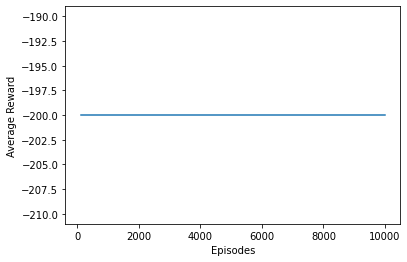

In [ ]:
Q = off_MC_control(env, 10000, 0.9)

**The average reward stay at -200 after 10000 episodes which means the MC controller still not learning greatly.**

In [ ]:
# Round State 0 to [-1.2, -1.1, ..., 0.5, 0.6] -> 19
# Round State 1 to [-0.07, -0.06, ..., 0.06, 0.07] -> 15

def round_state(state) :
  state[0] = round(state[0],1)
  state[1] = round(state[1],2)
  return state

In [ ]:
# Uniformly initial the Q for all the States

def initial_Q(Q):
  current_state_zero = -1.2
  for i in range (19) :
    current_state_one = -0.07
    for k in range (15) :
      Q[(round(current_state_zero,1),round(current_state_one,2))] = np.random.uniform(-1,1,3)
      current_state_one += 0.01
    current_state_zero += 0.1
  return Q

* **on-policy SARSA** 

In [ ]:
def On_Policy_Sarsa(env, max_episodes, alpha, gamma, epsilon):
  ## initial Q
  Q = initial_Q({})
  sum_reward = 0
  total_sum_reward = 0
  avg_reward = []

  ## Loop for each episode
  for e in range(max_episodes) :

    state = env.reset()
    state = tuple(round_state(state))

    ## Update the epsilon, we tend to explore at the beginning 
    ## We reduce the epsilon to take the best action to explore more
    current_epsilon = epsilon * (1 - e/max_episodes)

    ## Choose A from S using epsilon greedy policy
    rand = rand = random.random()
    if rand < 1-current_epsilon: 
      action = np.argmax(Q[state])
    else:
      action = np.random.choice(np.arange(actionSpaceSize))

    for i in range(200):
      next_state, reward, done, info = env.step(action)
      next_state = tuple(round_state(next_state))

      ## Choose A' from S' using epsilon greedy policy
      rand = rand = random.random()
      if rand < 1-current_epsilon: 
        next_action = np.argmax(Q[next_state])
      else:
        next_action = np.random.choice(np.arange(actionSpaceSize))
      
      Q[state][action] = Q[state][action] + alpha*(reward+gamma*Q[next_state][next_action]-Q[state][action])

      state = next_state
      action = next_action
      sum_reward += reward
      total_sum_reward += reward

      if done:
        break

    if (e+1) % 100 == 0:
      avg = sum_reward/100
      #print("For episode",e+1,"Average Reward:", avg)
      avg_reward.append(avg)
      sum_reward = 0
  
  l = np.arange(100, max_episodes+1, 100).tolist()
  plt.plot(l,avg_reward)
  plt.xlabel("Episodes")
  plt.ylabel("Average Reward")

  print("Max Average Reward is", np.max(avg_reward), "Total Average Reward is", total_sum_reward/max_episodes)

  return Q

Max Average Reward is -173.88 Total Average Reward is -196.7844


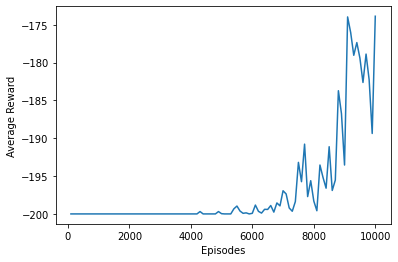

In [ ]:
Q = On_Policy_Sarsa(env, 10000, 0.2, 0.9, 0.8)

**From the plot, we can see the reward start to raise after 5500 episodes. The max average reward reaches -180.24. The reward curve looks unstable in last 2000 episodes.**

* **on-policy expected SARSA**

In [ ]:
def On_Policy_Exp_Sarsa(env, max_episodes, alpha, gamma, epsilon):
  ## initial Q
  Q = initial_Q({})
  sum_reward = 0
  avg_reward = []

  ## Loop for each episode
  for e in range(max_episodes) :

    state = env.reset()
    state = tuple(round_state(state))

    ## Update the epsilon, we tend to explore at the beginning 
    ## We reduce the epsilon to take the best action to explore more
    current_epsilon = epsilon * (1 - e/max_episodes)

    ## Choose A from S using epsilon greedy policy
    rand = rand = random.random()
    if rand < 1-current_epsilon: 
      action = np.argmax(Q[state])
    else:
      action = np.random.choice(np.arange(actionSpaceSize))

    for i in range(200):
      next_state, reward, done, info = env.step(action)
      next_state = tuple(round_state(next_state))

      ## Choose A' from S' using epsilon greedy policy
      rand = rand = random.random()
      if rand < 1-current_epsilon: 
        next_action = np.argmax(Q[next_state])
      else:
        next_action = np.random.choice(np.arange(actionSpaceSize))
      
      exp_val = 0

      for k in range(actionSpaceSize):
        if k == next_action :
          exp_val += (1-current_epsilon) * Q[next_state][k]
        else:
          exp_val += (current_epsilon/2) * Q[next_state][k]
      
      Q[state][action] = Q[state][action] + alpha*(reward+gamma*exp_val-Q[state][action])

      state = next_state
      action = next_action
      sum_reward += reward

      if done:
        break

    if (e+1) % 100 == 0:
      avg = sum_reward/100
      #print("For episode",e+1,"Average Reward:", avg)
      avg_reward.append(avg)
      sum_reward = 0
  
  l = np.arange(100, max_episodes+1, 100).tolist()
  plt.plot(l,avg_reward)
  plt.xlabel("Episodes")
  plt.ylabel("Average Reward")

  print("Max Average Reward is", np.max(avg_reward))

  return Q

Max Average Reward is -155.06


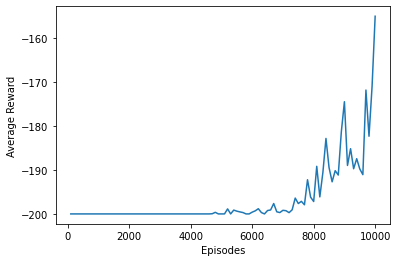

In [ ]:
Q = On_Policy_Exp_Sarsa(env, 10000, 0.2, 0.9, 0.8)

**From the plot, we can see the reward start to raise after 5000 episodes. The max average reward reaches -155.06 which is better than On policy Sarsa we showed above. The reward curve rise gradually after 8000 episodes.**

* **off-policy expected SARSA with a greedy control policy**

In [ ]:
def Off_Policy_Exp_Sarsa(env, max_episodes, alpha, gamma, epsilon):
  ## initial Q
  Q = initial_Q({})
  sum_reward = 0
  avg_reward = []

  ## Loop for each episode
  for e in range(max_episodes) :

    state = env.reset()
    state = tuple(round_state(state))

    ## Update the epsilon, we tend to explore at the beginning 
    ## We reduce the epsilon to take the best action to explore more
    current_epsilon = epsilon * (1 - e/max_episodes)


    for i in range(200):
    ## Choose A from S using epsilon greedy policy
      rand = rand = random.random()
      if rand < 1-current_epsilon: 
        action = np.argmax(Q[state])
      else:
        action = np.random.choice(np.arange(actionSpaceSize))

      next_state, reward, done, info = env.step(action)
      next_state = tuple(round_state(next_state))

      next_action = np.argmax(Q[next_state])
      exp_val = 0

      for k in range(actionSpaceSize):
        if k == next_action :
          exp_val += (1-current_epsilon) * Q[next_state][k]
        else:
          exp_val += (current_epsilon/2) * Q[next_state][k]
      
      Q[state][action] = Q[state][action] + alpha*(reward+gamma*exp_val-Q[state][action])

      state = next_state
      sum_reward += reward

      if done:
        break

    if (e+1) % 100 == 0:
      avg = sum_reward/100
      #print("For episode",e+1,"Average Reward:", avg)
      avg_reward.append(avg)
      sum_reward = 0
  
  l = np.arange(100, max_episodes+1, 100).tolist()
  plt.plot(l,avg_reward)
  plt.xlabel("Episodes")
  plt.ylabel("Average Reward")

  print("Max Average Reward is", np.max(avg_reward))

  return Q

Max Average Reward is -146.35


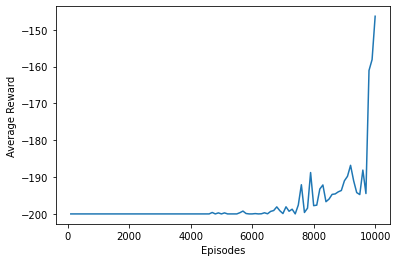

In [ ]:
Q = Off_Policy_Exp_Sarsa(env, 10000, 0.2, 0.9, 0.8)

**From the plot, we can see the reward start to raise after 5500 episodes. The max average reward reaches -146.35 which is the best for all TD(0) methods we tried. The reward curve rise rapidly at the end.**

In [ ]:
from prettytable import PrettyTable
 
myTable = PrettyTable(["Controllers", "Max Average Reward"])
 
# Add rows
myTable.add_row(["TD(0) on-policy SARSA", "-173.88"])
myTable.add_row(["TD(0) on-policy expected SARSA", "-155.06"])
myTable.add_row(["TD(0) off-policy expected SARSA with a greedy control policy", "-146.35"])
 
print(myTable)

+--------------------------------------------------------------+--------------------+
|                         Controllers                          | Max Average Reward |
+--------------------------------------------------------------+--------------------+
|                    TD(0) on-policy SARSA                     |      -173.88       |
|                TD(0) on-policy expected SARSA                |      -155.06       |
| TD(0) off-policy expected SARSA with a greedy control policy |      -146.35       |
+--------------------------------------------------------------+--------------------+


**From the table, we can see that TD(0) off-policy expected SARSA with a greedy control policy has the best performance and perform not good.**

In [ ]:
def n_step_Sarsa(env, max_episodes, alpha, gamma, epsilon, n):
  ## initial Q
  Q = initial_Q({})
  total_sum_reward = 0
  sum_reward = 0
  avg_reward = []

  ## Loop for each episode
  for e in range(max_episodes) :

    state_list = []
    action_list = []
    reward_list = []

    ## Initial the State 0
    state = env.reset()
    state = tuple(round_state(state))
    state_list.append(state)
    reward_list.append(-1)

    ## Update the epsilon, we tend to explore at the beginning 
    ## We reduce the epsilon to take the best action to explore more
    current_epsilon = epsilon * (1 - e/max_episodes)

    ## Choose A from S using epsilon greedy policy
    rand = rand = random.random()
    if rand < 1-current_epsilon: 
      action = np.argmax(Q[state])
    else:
      action = np.random.choice(np.arange(actionSpaceSize))
    
    action_list.append(action)
    T = math.inf

    for t in range(199):
      if t < T:
        action = action_list[t]
        next_state, reward, done, info = env.step(action)
        next_state = tuple(round_state(next_state))

        state_list.append(next_state)
        reward_list.append(reward)

        if done: T = t+1
        else: 
          ## Choose A' from S' using epsilon greedy policy
          rand = rand = random.random()
          if rand < 1-current_epsilon: 
            next_action = np.argmax(Q[next_state])
          else:
            next_action = np.random.choice(np.arange(actionSpaceSize))

          action_list.append(next_action)

      tau = t - n + 1

      if tau >=0:
        G = 0
        for i in range(int(np.min([T, tau+n])-(tau+1)+1)):
          G+= gamma**(i)*reward_list[tau+1+i]
        if tau+n < T: 
          G+=gamma**(n)* Q[state_list[tau+n]][action_list[tau+n]]
        Q[state_list[tau]][action_list[tau]]+=alpha*(G-Q[state_list[tau]][action_list[tau]])
      
      sum_reward += reward
      total_sum_reward += reward
      
      if tau == T-1: break

    if (e+1) % 100 == 0:
      avg = sum_reward/100
      #print("For episode",e+1,"Average Reward:", avg)
      avg_reward.append(avg)
      sum_reward = 0
  
  l = np.arange(100, max_episodes+1, 100).tolist()
  plt.plot(l,avg_reward)
  plt.xlabel("Episodes")
  plt.ylabel("Average Reward")

  print("Max Average Reward is", np.max(avg_reward), "Total Average Reward is", total_sum_reward/max_episodes)

  return Q

* **TD(2)**

Max Average Reward is -160.03 Total Average Reward is -195.2688


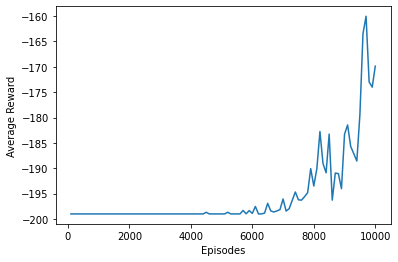

In [ ]:
Q = n_step_Sarsa(env, 10000, 0.2, 0.9, 0.8,2)

* **TD(3)**

Max Average Reward is -159.23 Total Average Reward is -194.4548


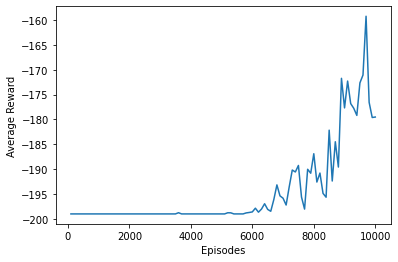

In [ ]:
Q = n_step_Sarsa(env, 10000, 0.2, 0.9, 0.8,3)

* **TD(4)**

Max Average Reward is -146.36 Total Average Reward is -194.2524


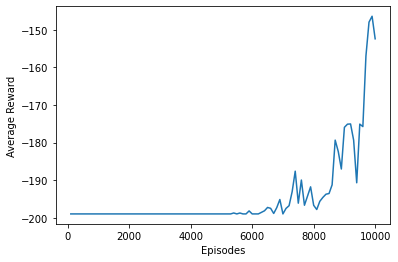

In [ ]:
Q = n_step_Sarsa(env, 10000, 0.2, 0.9, 0.8,4)

In [ ]:
from prettytable import PrettyTable
 
myTable = PrettyTable(["Controllers", "Max Average Reward", "Total Average Reward"])
 
# Add rows
myTable.add_row(["TD(0)", "-173.88", "-196.7844"])
myTable.add_row(["TD(2)", "-160.03", "-195.2688"])
myTable.add_row(["TD(3)", "-159.23", "-194.4548"])
myTable.add_row(["TD(4)", "-146.36", "-194.2524"])

 
print(myTable)

+-------------+--------------------+----------------------+
| Controllers | Max Average Reward | Total Average Reward |
+-------------+--------------------+----------------------+
|    TD(0)    |      -173.88       |      -196.7844       |
|    TD(2)    |      -160.03       |      -195.2688       |
|    TD(3)    |      -159.23       |      -194.4548       |
|    TD(4)    |      -146.36       |      -194.2524       |
+-------------+--------------------+----------------------+


**From the table above, we find TD(4) has the best Max Average Reward and Total Average Reward. As n goes up, the reward gradually grows.**